In [1]:
import numpy as np
from numpy import ma
import pandas as pd
import math
from sklearn import metrics, linear_model
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import keras

import tensorflow as tf
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import os
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import average_precision_score, matthews_corrcoef
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support

# Import Data

In [2]:
print(os.getcwd())
relative_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
train_df = pd.read_csv(relative_path+'/preprocessed_data/full_dataset_train_test_val/full_train_df_feats.csv')


test_df = pd.read_csv(relative_path+'/preprocessed_data/full_dataset_train_test_val/full_test_df_feats.csv')

validation_df = pd.read_csv(relative_path+'/preprocessed_data/full_dataset_train_test_val/full_val_df_feats.csv')




a:\Desktop\FYP Final Files\notebooks\Unsupervised_ML


In [3]:
train_df.head()

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus,evil
0,1,0,0,1,157,5,0,1,0
1,1,0,0,1,3,1,0,1,0
2,1,0,0,1,1010,0,0,1,0
3,1,1,0,0,21,2,2,1,0
4,1,1,0,0,1005,4,0,1,0


# Helpers

In [4]:
def split_data(df: pd.DataFrame) -> pd.DataFrame:
    features = df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]]
    labels = df['sus']
    return features, labels

In [5]:
def print_metrics(y_true, y_predicted):

    accuracy = accuracy_score(y_true, y_predicted)   
    metrics_results = precision_recall_fscore_support(y_true, y_predicted, average="weighted", pos_label=1)
    average_precision = average_precision_score(y_true, y_predicted)
    balanced_accuracy = balanced_accuracy_score(y_true, y_predicted)
    mcc = matthews_corrcoef(y_true, y_predicted)
    
    print(f'Accuracy:\t{accuracy:.3f}')
    print(f'Precision:\t{metrics_results[0]}')
    print(f'Recall:\t\t{metrics_results[1]:.3f}')
    print(f'F1-Score:\t{metrics_results[2]:.3f}')
    print("Average Precision Score:", average_precision)
    print("Balanced Accuracy Score:", balanced_accuracy)
    print("Matthews Correlation Coefficient (MCC):", mcc)
    print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_true , y_predicted)))
    
    #make confusion matrix
    confusion_matrixs = confusion_matrix(y_true, y_predicted)
    

    TP = confusion_matrixs[1][1]
    TN = confusion_matrixs[0][0]
    FP = confusion_matrixs[0][1]
    FN = confusion_matrixs[1][0]


    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrixs, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

    # Print roc curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_predicted)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, )
    display.plot()
    plt.show()


    precision, recall, _ = precision_recall_curve(y_true, y_predicted)

    # Calculate the area under the curve
    pr_auc = auc(recall, precision)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

In [6]:
def normal_accuracy(values):
    
    tp=list(values).count(1)
    total=values.shape[0]
    accuracy=np.round(tp/total,4)
    
    return accuracy

def fraud_accuracy(values):
    
    tn=list(values).count(-1)
    total=values.shape[0]
    accuracy=np.round(tn/total,4)
    
    return accuracy

In [7]:
def prepare_labels(y_predicted):
    """
    Helper function to help map out the outputs from models that return -1 for outliers and 1 for inliners.
    """
    y_predicted[y_predicted == 1] = 0
    y_predicted[y_predicted == -1] = 1
    return y_predicted

# Split data

In [8]:
train_df_feats, train_df_labels = split_data(train_df)
test_df_feats, test_df_labels = split_data(test_df)
val_df_feats, val_df_labels = split_data(validation_df)

In [9]:
train_df_feats=train_df_feats.drop(columns="userId",axis=1)
test_df_feats=test_df_feats.drop(columns="userId",axis=1)
val_df_feats=val_df_feats.drop(columns="userId",axis=1)

In [10]:
train_df_feats.head()
train_df_feats.shape

(763144, 6)

In [11]:
train_df_feats.head()

,processId,parentProcessId,mountNamespace,eventId,argsNum,returnValue
0,1,0,1,157,5,0
1,1,0,1,3,1,0
2,1,0,1,1010,0,0
3,1,1,0,21,2,2
4,1,1,0,1005,4,0


In [12]:
train_df_labels.head()
train_df_labels.shape

(763144,)

In [13]:
train_df_feats.head()

,processId,parentProcessId,mountNamespace,eventId,argsNum,returnValue
0,1,0,1,157,5,0
1,1,0,1,3,1,0
2,1,0,1,1010,0,0
3,1,1,0,21,2,2
4,1,1,0,1005,4,0


# Model training

## Isolation forest

In [14]:
iforest = IsolationForest(random_state=0,contamination=0.05)
iforest.fit(train_df_feats)

IsolationForest(contamination=0.05, random_state=0)

In [15]:
ypred_iforest = iforest.predict(val_df_feats)
ypred_iforest = prepare_labels(ypred_iforest)
print(classification_report(val_df_labels, ypred_iforest,digits=3))

              precision    recall  f1-score   support

           0      0.997     0.929     0.962    188181
           1      0.017     0.296     0.032       786

    accuracy                          0.926    188967
   macro avg      0.507     0.613     0.497    188967
weighted avg      0.993     0.926     0.958    188967



Accuracy:	0.926
Precision:	0.992770007886795
Recall:		0.926
F1-Score:	0.958
Average Precision Score: 0.007980584012033096
Balanced Accuracy Score: 0.6125271284415106
Matthews Correlation Coefficient (MCC): 0.05592081420445186
AUC : 0.61253


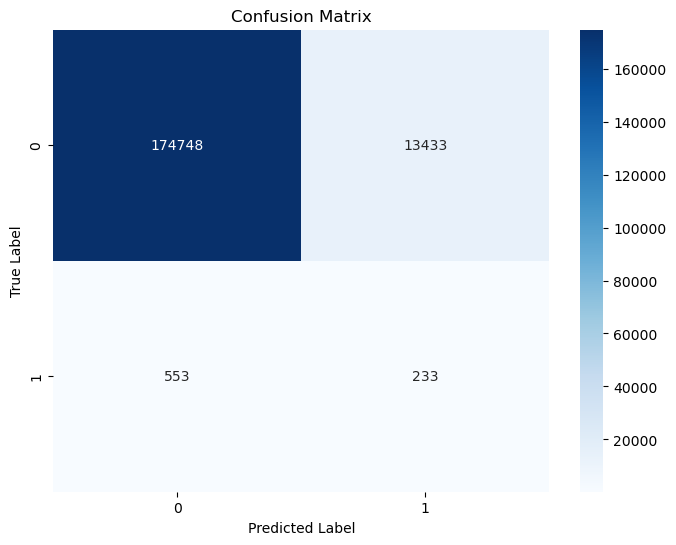

True Positives (TP): 233
True Negatives (TN): 174748
False Positives (FP): 13433
False Negatives (FN): 553


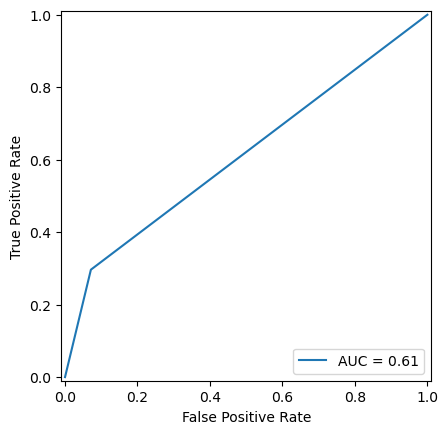

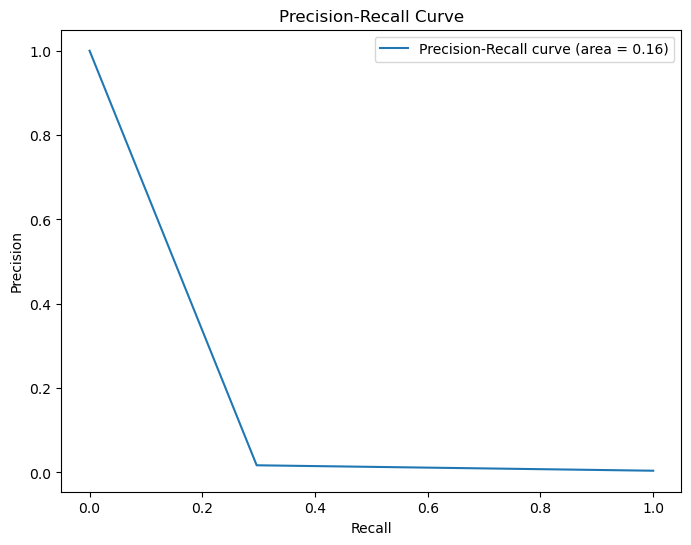

In [16]:
print_metrics(val_df_labels,ypred_iforest)

In [17]:
ypred_iforest_test = iforest.predict(test_df_feats)
ypred_iforest_test = prepare_labels(ypred_iforest_test)
print(classification_report(test_df_labels, ypred_iforest_test,digits=3))

              precision    recall  f1-score   support

           0      0.365     0.845     0.510     17508
           1      0.982     0.850     0.911    171459

    accuracy                          0.850    188967
   macro avg      0.673     0.847     0.711    188967
weighted avg      0.925     0.850     0.874    188967



Accuracy:	0.850
Precision:	0.92455895736666
Recall:		0.850
F1-Score:	0.874
Average Precision Score: 0.970533122798295
Balanced Accuracy Score: 0.847344719470279
Matthews Correlation Coefficient (MCC): 0.4909004493360064
AUC : 0.84734


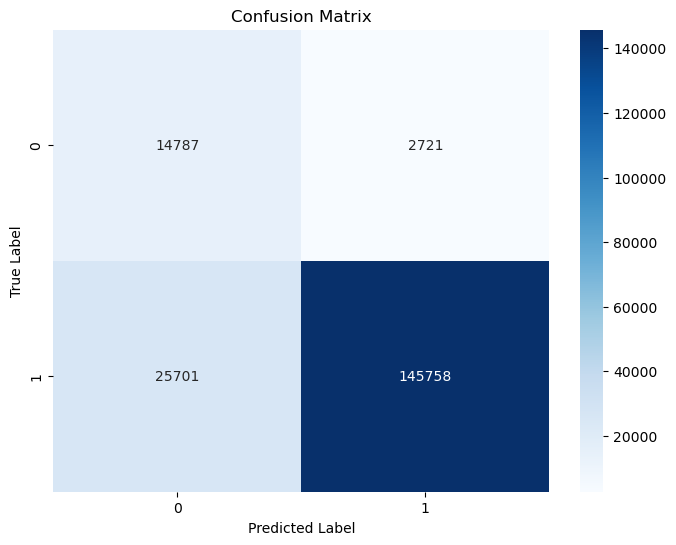

True Positives (TP): 145758
True Negatives (TN): 14787
False Positives (FP): 2721
False Negatives (FN): 25701


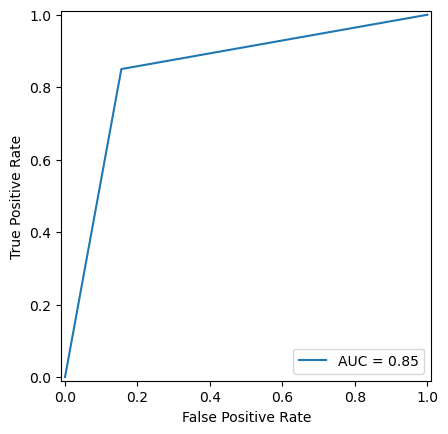

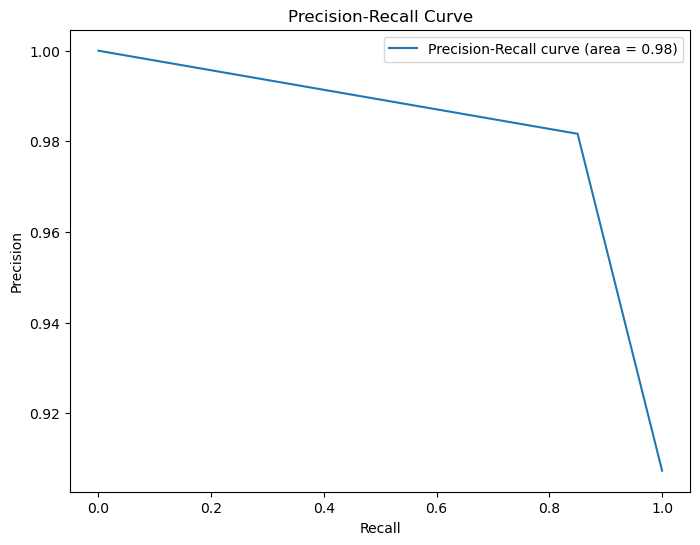

In [18]:
print_metrics(test_df_labels,ypred_iforest_test)

## Local Outlier Factor

In [19]:
lof = LocalOutlierFactor(contamination=0.05, novelty=True)
lof.fit(train_df_feats)

LocalOutlierFactor(contamination=0.05, novelty=True)

In [20]:
predicted_scores = lof.decision_function(test_df_feats)
predicted_labels = lof.predict(test_df_feats)
predicted_labels = (predicted_labels == -1).astype(int)

c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Accuracy:	0.093
Precision:	0.5745187320504219
Recall:		0.093
F1-Score:	0.018
Average Precision Score: 0.9069238701928958
Balanced Accuracy Score: 0.49632290244207034
Matthews Correlation Coefficient (MCC): -0.045715758054861805
AUC : 0.49632


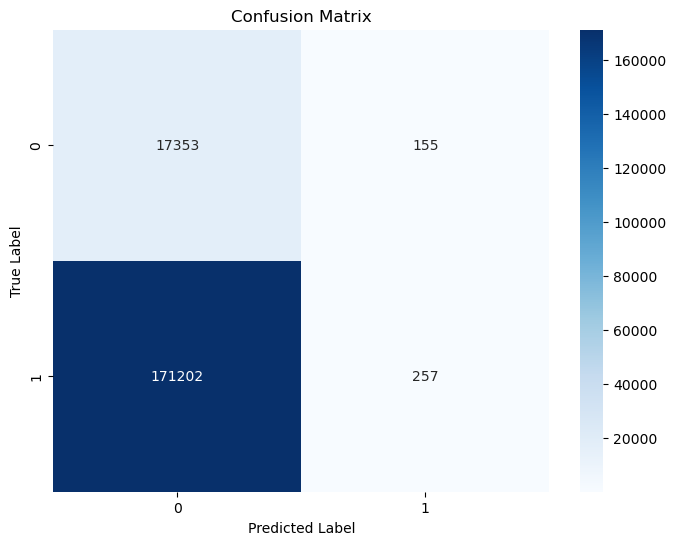

True Positives (TP): 257
True Negatives (TN): 17353
False Positives (FP): 155
False Negatives (FN): 171202


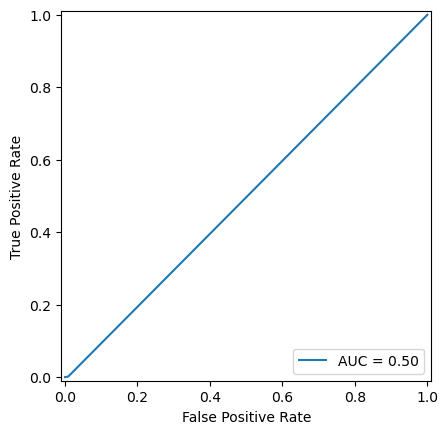

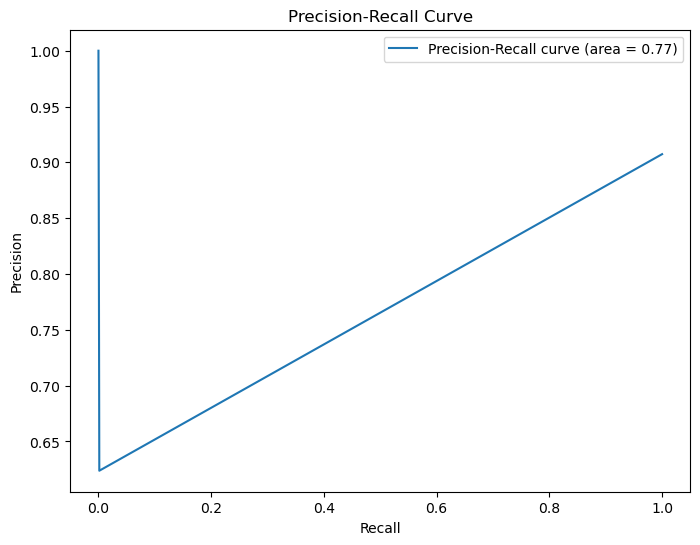

In [21]:
print_metrics(test_df_labels,predicted_labels)

In [22]:
predicted_scores = lof.decision_function(val_df_feats)
predicted_labels = lof.predict(val_df_feats)
predicted_labels = (predicted_labels == -1).astype(int)

c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\Kamil\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Accuracy:	0.995
Precision:	0.9921340436929935
Recall:		0.995
F1-Score:	0.994
Average Precision Score: 0.005473442787020678
Balanced Accuracy Score: 0.5073120888038968
Matthews Correlation Coefficient (MCC): 0.035489893414010466
AUC : 0.50731


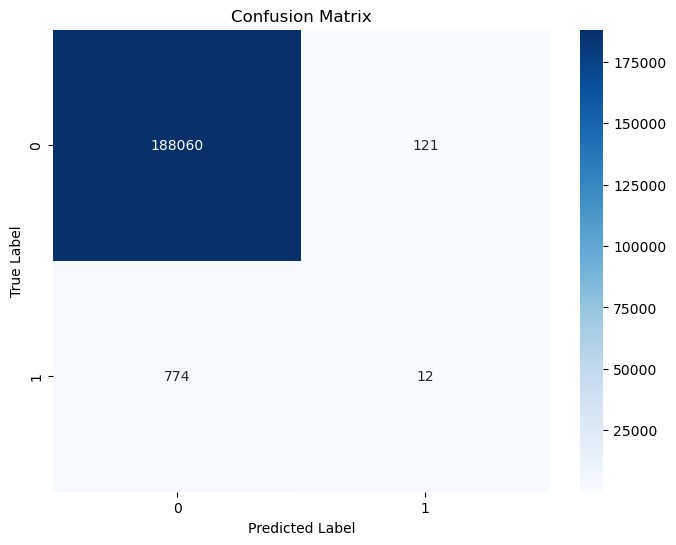

True Positives (TP): 12
True Negatives (TN): 188060
False Positives (FP): 121
False Negatives (FN): 774


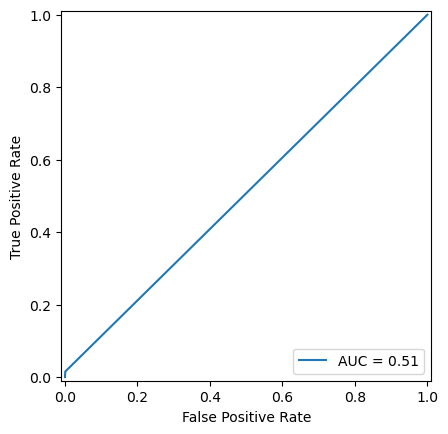

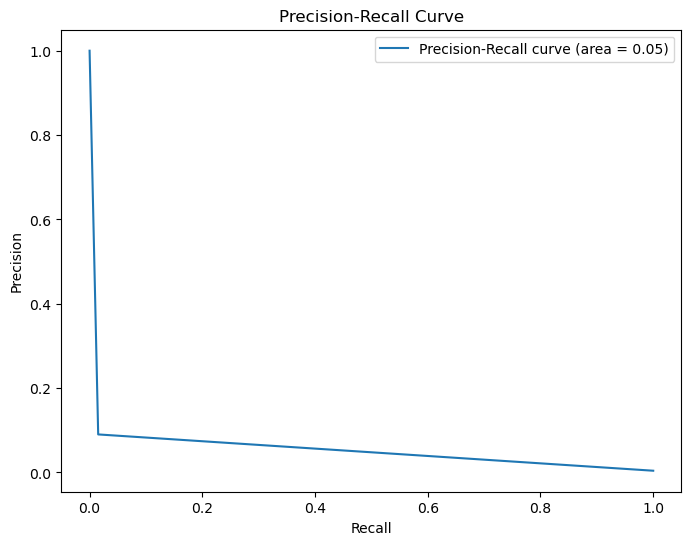

In [23]:
print_metrics(val_df_labels,predicted_labels)

## SVM

In [24]:
model = linear_model.SGDOneClassSVM(random_state=0).fit(train_df_feats)

Accuracy:	0.701
Precision:	0.9910823536166431
Recall:		0.701
F1-Score:	0.821
Average Precision Score: 0.0038757132719504897
Balanced Accuracy Score: 0.4464956306683946
Matthews Correlation Coefficient (MCC): -0.015084973443520134
AUC : 0.44650


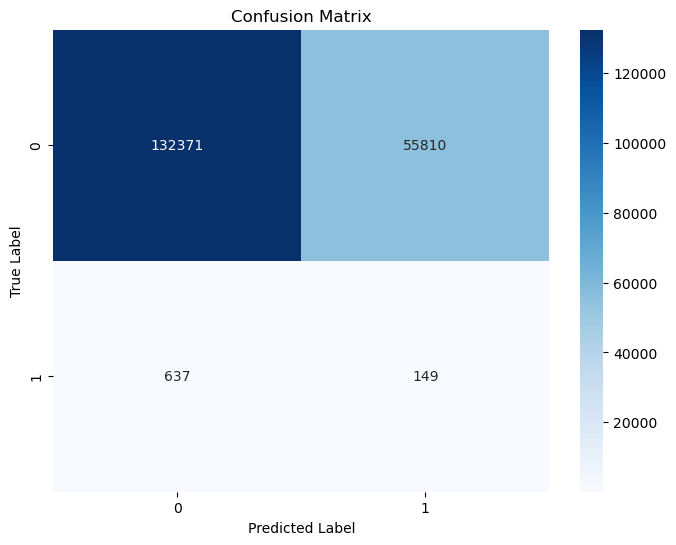

True Positives (TP): 149
True Negatives (TN): 132371
False Positives (FP): 55810
False Negatives (FN): 637


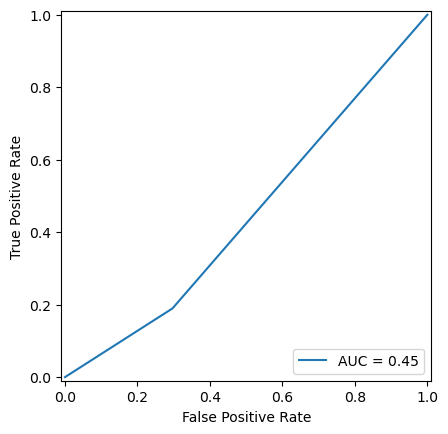

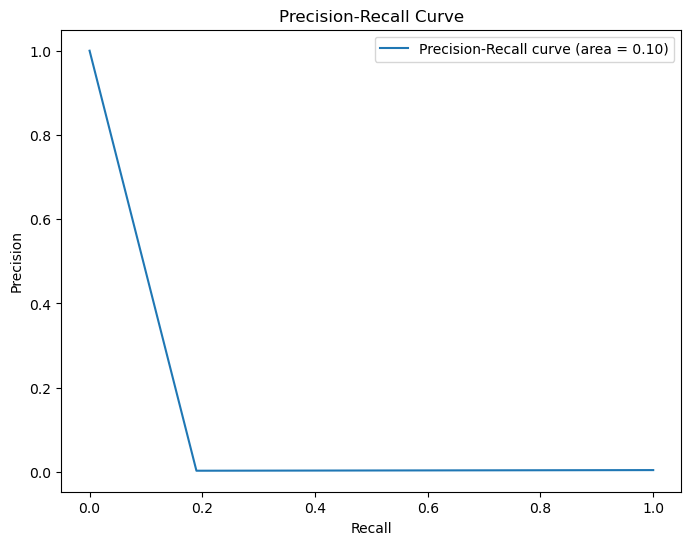

In [25]:
y_pred_svm_val = model.predict(val_df_feats)
y_pred_svm_val = prepare_labels(y_pred_svm_val)
print_metrics(val_df_labels,y_pred_svm_val)

Accuracy:	0.105
Precision:	0.5545655096019705
Recall:		0.105
F1-Score:	0.078
Average Precision Score: 0.8956140810884428
Balanced Accuracy Score: 0.39509056353714944
Matthews Correlation Coefficient (MCC): -0.26010006220217413
AUC : 0.39509


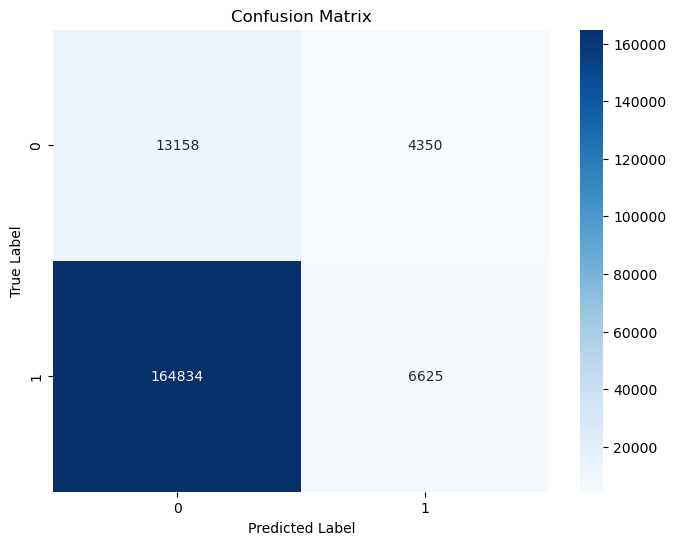

True Positives (TP): 6625
True Negatives (TN): 13158
False Positives (FP): 4350
False Negatives (FN): 164834


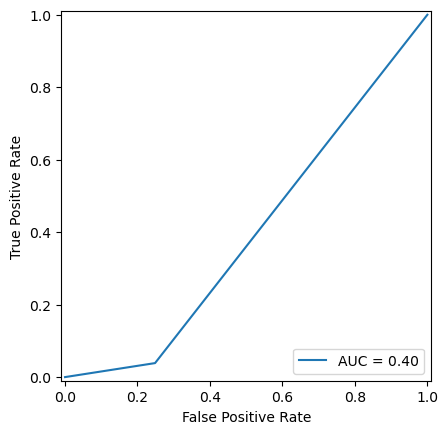

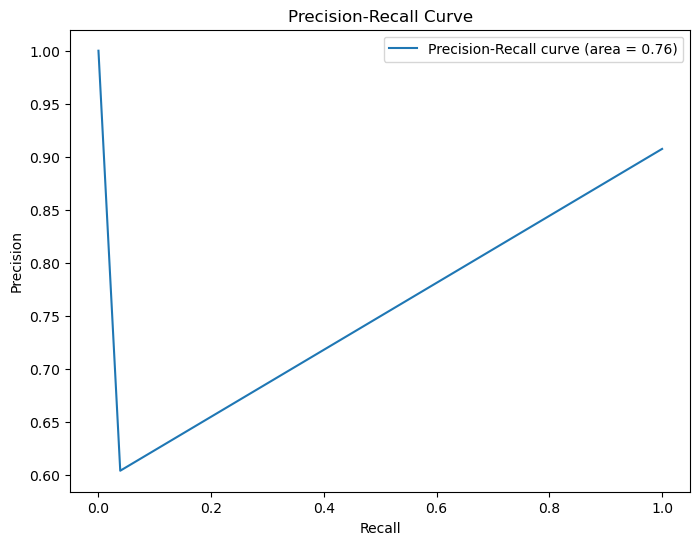

In [26]:
y_pred_svm_test = model.predict(test_df_feats)
y_pred_svm_test = prepare_labels(y_pred_svm_test)
print_metrics(test_df_labels,y_pred_svm_test)

## Autoenconder

In [27]:
input_dim = train_df_feats.shape[1] # Number of features

In [28]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

input_dim = train_df_feats.shape[1] # Number of features

# Encoder
input_layer = Input(shape=(input_dim, ))
encoder = Dense(128, activation="relu")(input_layer)
encoder = Dense(64, activation="relu")(encoder)

# Bottleneck
bottleneck = Dense(32, activation="relu")(encoder)

# Decoder
decoder = Dense(64, activation="relu")(bottleneck)
decoder = Dense(128, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [29]:
checkpoint = ModelCheckpoint("best_weights4.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = autoencoder.fit(
    train_df_feats, train_df_feats,
    epochs=20,
    batch_size=256,
    validation_data=(val_df_feats, val_df_feats),
    shuffle=True,
    callbacks=[checkpoint]
)
autoencoder.load_weights("best_weights4.keras")

Epoch 1/20
2973/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 931.2888
Epoch 1: val_loss improved from inf to 0.03289, saving model to best_weights4.keras
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 928.6577 - val_loss: 0.0329
Epoch 2/20
2950/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1328
Epoch 2: val_loss improved from 0.03289 to 0.02720, saving model to best_weights4.keras
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1369 - val_loss: 0.0272
Epoch 3/20
2981/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2910
Epoch 3: val_loss did not improve from 0.02720
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2911 - val_loss: 9.3269
Epoch 4/20
2953/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4931
Epoch 4: val_loss did not improve from 0.02720
2982/2982 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4922 - val_loss: 12.5504
Epoch 5/20
2981/2982 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5505
Epoch 5: val_loss improved from 0.02720 to 0.00625, saving model to best_wei

In [30]:
# Predict on the test set
X_test_pred = autoencoder.predict(test_df_feats)
# Predict on the val set
X_val_pred = autoencoder.predict(val_df_feats)

X_train_pred = autoencoder.predict(train_df_feats)

5906/5906 ━━━━━━━━━━━━━━━━━━━━ 5s 889us/step
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 4s 735us/step
23849/23849 ━━━━━━━━━━━━━━━━━━━━ 18s 746us/step


In [31]:
mse_train = np.mean(np.power(train_df_feats - X_train_pred, 2), axis=1)
mse_test = np.mean(np.power(test_df_feats - X_test_pred, 2), axis=1)
mse_val = np.mean(np.power(val_df_feats - X_val_pred, 2), axis=1)

In [32]:

threshold = np.quantile(mse_train, 0.99)

# Predict anomalies on the test set
y_pred_test = (mse_test > threshold)
y_pred_test = y_pred_test.astype(int)

In [33]:
y_pred_val = (mse_val > threshold)
y_pred_val = y_pred_val.astype(int)

In [34]:
from sklearn.metrics import classification_report, roc_auc_score

# Calculate classification metrics
print(classification_report(test_df_labels, y_pred_test))

# Calculate AUC-ROC
roc_auc = roc_auc_score(test_df_labels, y_pred_test) # Using raw MSE scores for AUC calculation
print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       0.09      0.97      0.16     17508
           1       0.04      0.00      0.00    171459

    accuracy                           0.09    188967
   macro avg       0.07      0.48      0.08    188967
weighted avg       0.05      0.09      0.02    188967

AUC-ROC: 0.48


Accuracy:	0.090
Precision:	0.045411862505982094
Recall:		0.090
F1-Score:	0.016
Average Precision Score: 0.9072326678970256
Balanced Accuracy Score: 0.4846455498380246
Matthews Correlation Coefficient (MCC): -0.1633666562213359
AUC : 0.48465


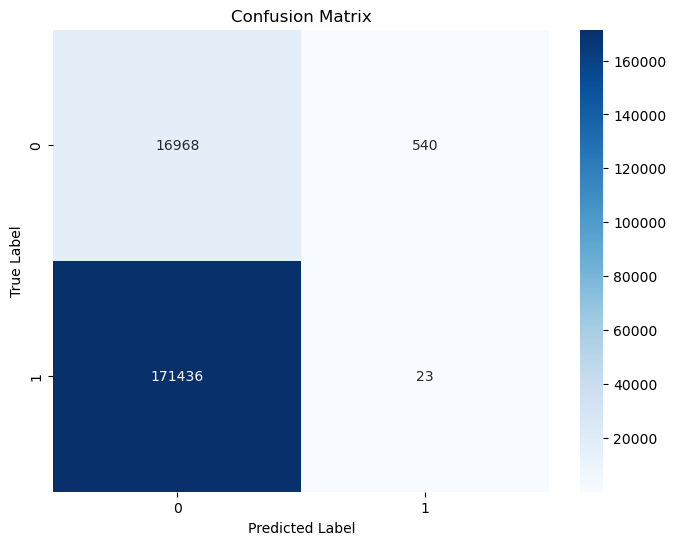

True Positives (TP): 23
True Negatives (TN): 16968
False Positives (FP): 540
False Negatives (FN): 171436


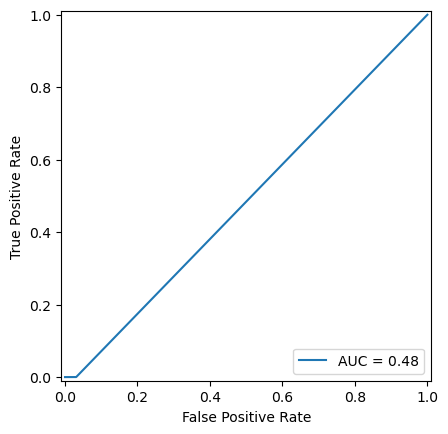

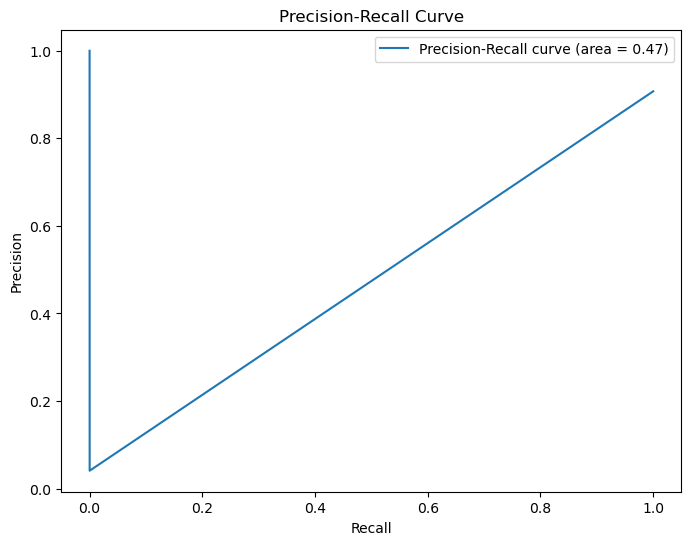

In [35]:
print_metrics(test_df_labels,y_pred_test)

In [36]:
from sklearn.metrics import classification_report, roc_auc_score

# Calculate classification metrics
print(classification_report(val_df_labels, y_pred_val))

# Calculate AUC-ROC
roc_auc = roc_auc_score(val_df_labels, y_pred_val) # Using raw MSE scores for AUC calculation
print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    188181
           1       0.00      0.01      0.00       786

    accuracy                           0.98    188967
   macro avg       0.50      0.50      0.50    188967
weighted avg       0.99      0.98      0.99    188967

AUC-ROC: 0.50


Accuracy:	0.982
Precision:	0.9916971569450004
Recall:		0.982
F1-Score:	0.987
Average Precision Score: 0.004148890364822071
Balanced Accuracy Score: 0.4983003816651915
Matthews Correlation Coefficient (MCC): -0.001891379359456809
AUC : 0.49830


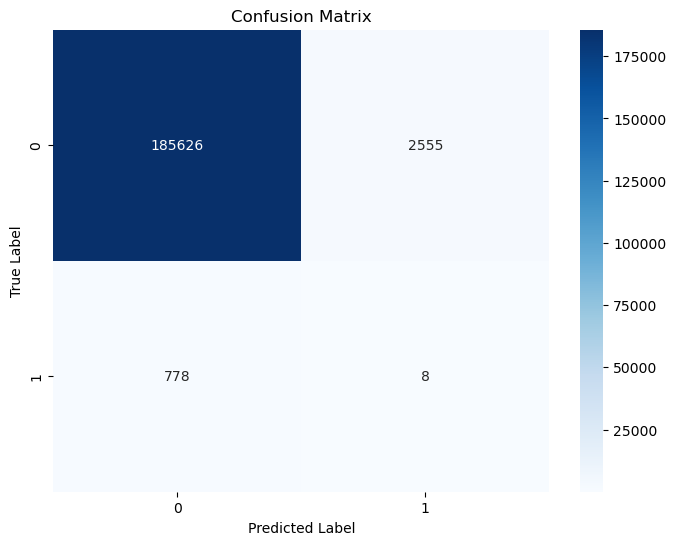

True Positives (TP): 8
True Negatives (TN): 185626
False Positives (FP): 2555
False Negatives (FN): 778


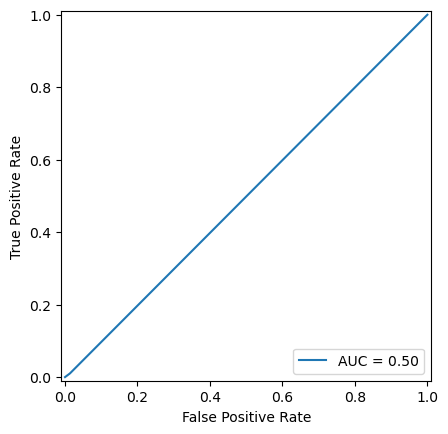

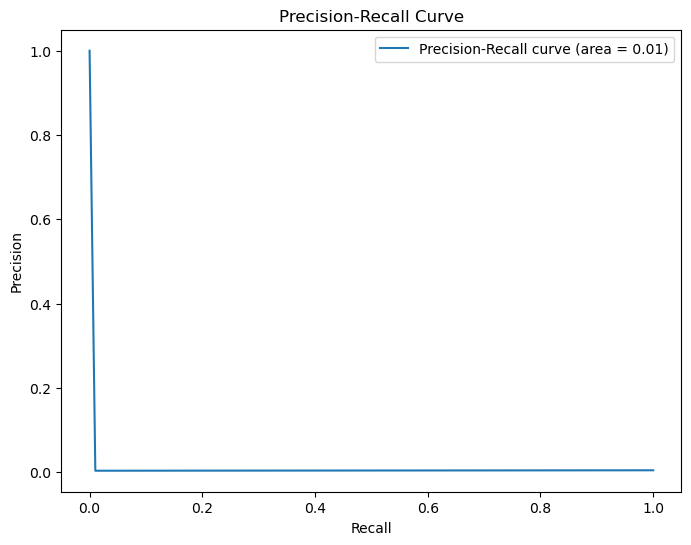

In [37]:
print_metrics(val_df_labels,y_pred_val)